<h1 align="center"><a href="https://github.com/sborquez/her2bdl"> Her2BDL</a> - Her2 Bayesian Deep Learning</h1>

<br>
<img src="images/utfsm.png" width="50%"/>

<h2 align="center">Exploratory Data Analysis</h2>

<center>
<i> Notebook created by Sebastián Bórquez G. - <a href="mailto://sebstian.borquez@sansano.usm.cl">sebastian.borquez@sansano.usm.cl</a> - utfsm - Agosto 2020.</i>
</center>


# Setup Notebook


## (Option A) Colab Setup

Connectar a tu `Google Drive` e instalar dependencias.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/<Path to Project>"
!ls

## (Opción B) Local Setup

Cambiarse al directorio raíz del proyecto.

In [1]:
%cd ..

d:\sebas\Google Drive\Projects\her2bdl


## Importar Modulos

In [2]:
# Her2BDL packege
from her2bdl import *

# Adhoc modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML

# Exploratory Data Analysis

Descripción y exploración del datasets, distribución de clases y ejemplos.


## Warwick Her2 Scoring contest

### Descripción

WSIs are generally high resolution gigapixel images obtained by scanning the conventional glass slides. They are normally stored in pyramid structures containing several levels, each level has a different resolution. For visualization, the region-of-interest (ROI) from these images require specially designed libraries or tools. OpenSlide is one of the commonly used libraries that provides a simple interface to read WSIs.

### Fuente

- https://warwick.ac.uk/fac/sci/dcs/research/tia/her2contest/download/

- Qaiser, Talha, et al. "Her 2 challenge contest: a detailed assessment of automated her 2 scoring algorithms in whole slide images of breast cancer tissues." Histopathology 72.2 (2018): 227-238.
https://onlinelibrary.wiley.com/doi/epdf/10.1111/his.13333

- T. Qaiser, N.M. Rajpoot, "Learning Where to See: A Novel Attention Model for Automated Immunohistochemical Scoring", in IEEE Transactions on Medical Imaging, 2019. DOI: 10.1109/TMI.2019.2907049
https://ieeexplore.ieee.org/document/8672928


### The Training Dataset

The training dataset consists of 52 WSIs with equally distributed cases for all 4 possible stages of HER2 scoring (0/ 1+/2+/3+).

The ground truth data for WSIs is provided in a spreadsheet containing the case number, HER2 score and percentage cells with complete membrane staining irrespective of intensity respectively.

In [3]:
source = 'E:/datasets/medical/warwick/train'

train_dataset = get_dataset(source, include_ground_truth=True)
describe_dataset(train_dataset)
train_dataset.sample(5)

Dataset Info:
  size: 52
  columns: Index(['CaseNo', 'HeR2 SCORE', 'source', 'image_her2', 'image_he'], dtype='object')
  by class:
    Score 3: 13
    Score 2: 13
    Score 1: 13
    Score 0: 13


,CaseNo,HeR2 SCORE,source,image_her2,image_he
7,14,1,E:/datasets/medical/warwick/train,14_Her2.ndpi,14_HE.ndpi
38,65,1,E:/datasets/medical/warwick/train,65_Her2.ndpi,65_HE.ndpi
43,73,0,E:/datasets/medical/warwick/train,73_Her2.ndpi,73_HE.ndpi
0,1,0,E:/datasets/medical/warwick/train,01_Her2.ndpi,01_HE.ndpi
19,32,1,E:/datasets/medical/warwick/train,32_Her2.ndpi,32_HE.ndpi


### The Testing Dataset

The testing dataset contains 28 whole-slide-images (WSIs)

In [4]:
source = 'E:/datasets/medical/warwick/test'

test_dataset = get_dataset(source, include_ground_truth=False)
describe_dataset(test_dataset, include_targets=False)
test_dataset.sample(1)

Dataset Info:
  size: 29
  columns: Index(['source', 'CaseNo', 'image_her2', 'image_he', 'HeR2 SCORE'], dtype='object')


,source,CaseNo,image_her2,image_he,HeR2 SCORE
4,E:/datasets/medical/warwick/test,8,08_Her2.ndpi,08_HE.ndpi,None


## Preparación del Dataset

El train set se divide en `train/validation/test` con una razón de 80%, 10% y 10% respectivamente.
La división de un dataset debe mantener el balance de clases. 

In [5]:
source = 'E:/datasets/medical/warwick/train'
# 1. Get Dataset from source
dataset = get_dataset(source, include_ground_truth=True)
    
# 2. Split train/validation/test
train, val, test = split_dataset(dataset, validation_ratio=0.1, test_ratio=0.1, seed=42)

# 3. Save
print('train split')
describe_dataset(train)
save_dataset(train, "./train/datasets", "train")

print()
print('validation split')
describe_dataset(val)
save_dataset(val, "./train/datasets", "validation")

print()
print('test split')
describe_dataset(test)
save_dataset(test, "./train/datasets", "test");

train split
Dataset Info:
  size: 36
  columns: Index(['CaseNo', 'HeR2 SCORE', 'source', 'image_her2', 'image_he'], dtype='object')
  by class:
    Score 3: 9
    Score 2: 9
    Score 1: 9
    Score 0: 9

validation split
Dataset Info:
  size: 8
  columns: Index(['CaseNo', 'HeR2 SCORE', 'source', 'image_her2', 'image_he'], dtype='object')
  by class:
    Score 3: 2
    Score 2: 2
    Score 1: 2
    Score 0: 2

test split
Dataset Info:
  size: 8
  columns: Index(['CaseNo', 'HeR2 SCORE', 'source', 'image_her2', 'image_he'], dtype='object')
  by class:
    Score 3: 2
    Score 2: 2
    Score 1: 2
    Score 0: 2


## Visualizaciones 

In [6]:
train = load_dataset("./train/datasets/train.csv")
val = load_dataset("./train/datasets/validation.csv")
test = load_dataset("./train/datasets/test.csv")

### Clases balanceadas

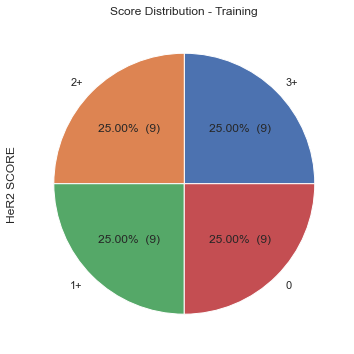

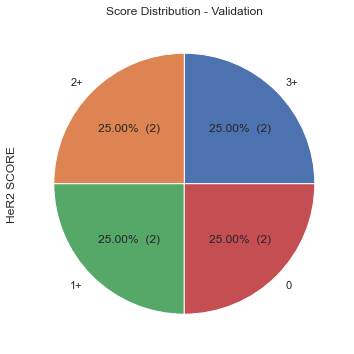

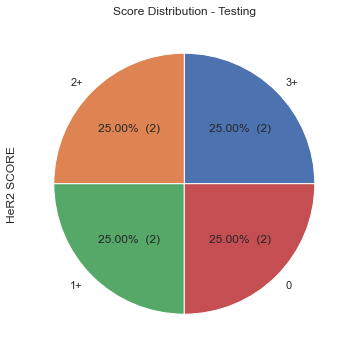

In [7]:
display_class_distribution(train, target=TARGET, target_labels=TARGET_LABELS, dataset_name="Training")
display_class_distribution(val, target=TARGET, target_labels=TARGET_LABELS, dataset_name="Validation")
display_class_distribution(test, target=TARGET, target_labels=TARGET_LABELS, dataset_name="Testing")

## WSI: Imágenes de ejemplo

A whole-slide image is a digital representation of a microscopic slide, typically at a very high level of magnification such as 20x or 40x. As a result of this high magnification, whole slide images are typically very large in size. The maximum file size for a single whole-slide image in our training data set is 3.4 GB, with an average over 1 GB. [[source](https://developer.ibm.com/articles/an-automatic-method-to-identify-tissues-from-big-whole-slide-images-pt1/)]

We can use the [OpenSlide](https://openslide.org/api/python) project to read a variety of whole-slide image formats. This is a pyramidal, tiled format, where the massive slide is composed of a large number of constituent tiles.

In [8]:
samples = train_dataset.sample(5)
wsi_images = []
for _,sample in samples.iterrows():
    wsi_images.append(open_wsi(sample["source"], sample["CaseNo"],sample["image_her2"]))
her2_wsi = open_wsi(sample["source"], sample["CaseNo"],sample["image_her2"])
describe_wsi(her2_wsi)

OpenSlide('E:/datasets/medical/warwick/train\\35\\35_Her2.ndpi')
model: Hamamatsu C9600-01 NDP.scan 2.5.89
vendor: hamamatsu
datetime: 2015:12:04 19:14:15
dimensions: (151552, 34560)
levels: 9
	[0]: dimensions=(151552, 34560)	downsample=1.0
	[1]: dimensions=(75776, 17280)	downsample=2.0
	[2]: dimensions=(37888, 8640)	downsample=4.0
	[3]: dimensions=(18944, 4320)	downsample=8.0
	[4]: dimensions=(9472, 2160)	downsample=16.0
	[5]: dimensions=(4736, 1080)	downsample=32.0
	[6]: dimensions=(2368, 540)	downsample=64.0
	[7]: dimensions=(1184, 270)	downsample=128.0
	[8]: dimensions=(592, 135)	downsample=256.0



(432, 159)

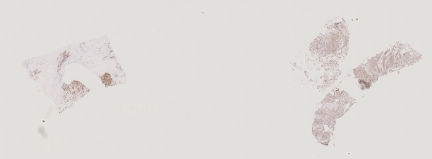

(544, 193)

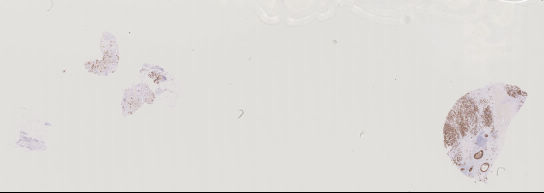

(480, 155)

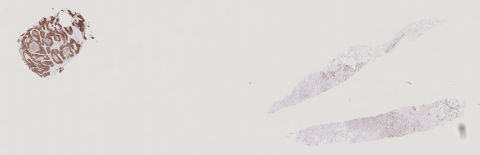

(66, 53)

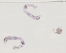

(592, 135)

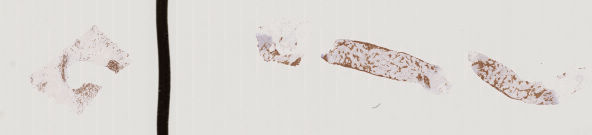

In [9]:
for her2_wsi in wsi_images:
    size = her2_wsi.level_dimensions[-1]
    display(size)
    display(her2_wsi.get_thumbnail(size))

### Estadísticas de imágenes

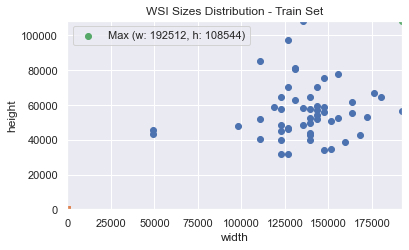

In [10]:
display_wsi_sizes_distribution(train_dataset, "Train Set")

# SandBox

In [11]:
import cv2

## Otsu

In [12]:
size = her2_wsi.level_dimensions[5]
image = cv2.cvtColor(np.array(her2_wsi.get_thumbnail(size)),  cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

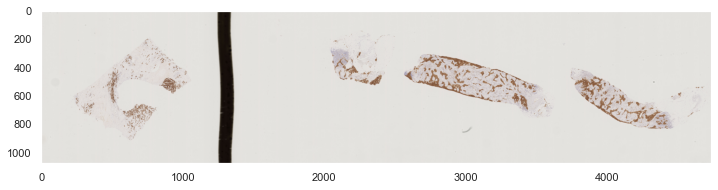

In [13]:
plt.figure(figsize=(12, 6))
plt.imshow(image[:,:,::-1], interpolation=None)
plt.grid(False)

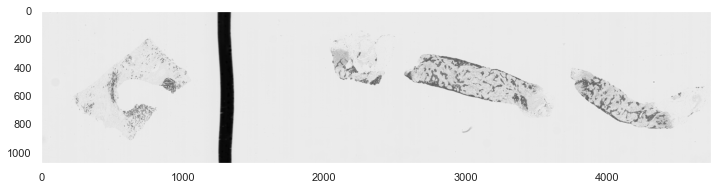

In [14]:
plt.figure(figsize=(12, 6))
plt.imshow(gray, interpolation=None, cmap="gray")
plt.grid(False)

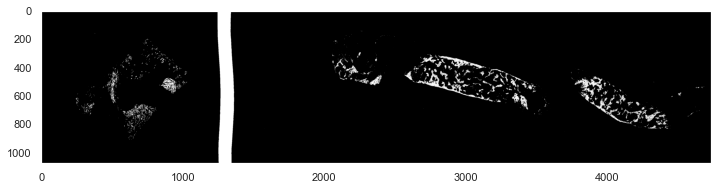

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(th2, interpolation=None, cmap="binary")
plt.grid(False)

## OTSU with HSV


In [23]:
size = her2_wsi.level_dimensions[5]
image = cv2.cvtColor(np.array(her2_wsi.get_thumbnail(size)),  cv2.COLOR_RGB2HSV)

# Otsu's thresholding
ret2,th2 = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

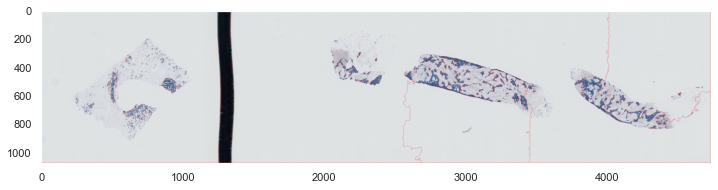

In [25]:
plt.figure(figsize=(12,6))
plt.imshow(img, interpolation=None)
plt.grid(False)